# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd

In [2]:
train_fname = '../../data/nlp/tweet_sentiment_train.csv.zip'
raw_df = pd.read_csv(train_fname)

raw_df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
raw_df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [8]:
raw_df = raw_df.dropna().reset_index(drop=True)

In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [12]:
raw_df.sentiment.value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

У даних більше нейтральних текстів і трохи менше позитивних та негативних

In [13]:
import matplotlib.pyplot as plt

def get_lens(df):
    return [len(text) for text in df]

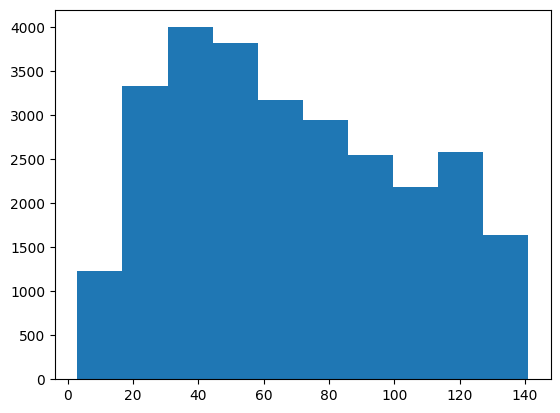

In [14]:
# Розподіл всіх даних
lens = get_lens(raw_df.text)
plt.hist(lens);

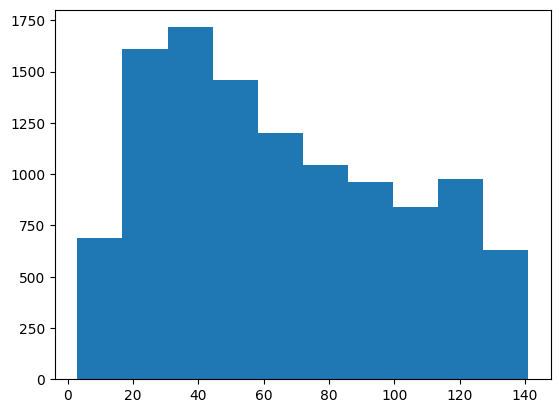

In [16]:
# розподіл довжин нейтральних записів
neutral_lens = get_lens(raw_df[raw_df.sentiment == 'neutral'].text)
plt.hist(neutral_lens);

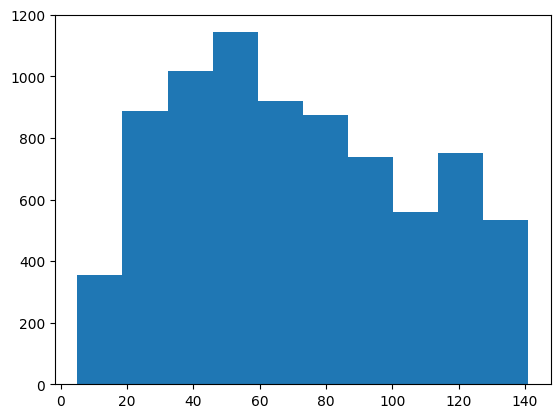

In [17]:
# розподіл довжин негативних записів
negative_lens = get_lens(raw_df[raw_df.sentiment == 'negative'].text)
plt.hist(negative_lens);

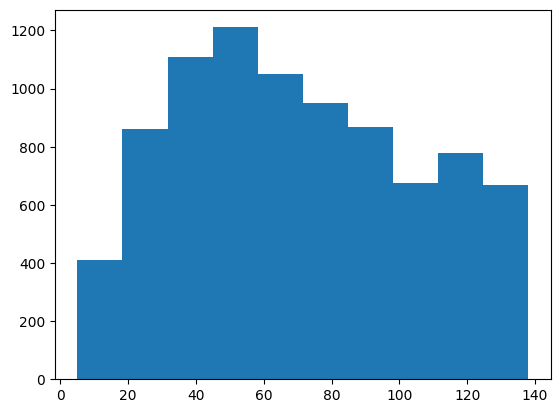

In [18]:
# розподіл довжин розитивних записів
positive_lens = get_lens(raw_df[raw_df.sentiment == 'positive'].text)
plt.hist(positive_lens);

* У даних найбільше повідомлень від прилизно 20 до приблизно 60 символів
* Серед нейтральних текстів більше даних від 20 до 40 символів
* Серед позитивних та негативних більше даних від 30 до 60 символів

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [19]:
import nltk

from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')


def tokenize(text):
    return [stemmer.stem(w) for w in word_tokenize(text)]

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
from sklearn.feature_extraction.text import CountVectorizer

max_features = 1000

bow_vectorizer = CountVectorizer(
    lowercase=True,
    tokenizer=tokenize,
    stop_words=english_stopwords,
    max_features=max_features
)

bow_vectorizer.fit(raw_df.text)
bow_vectors = bow_vectorizer.transform(raw_df.text)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


In [21]:
bow_vectorizer.get_feature_names_out()[100:110]

array(['ask', 'asleep', 'ate', 'avail', 'aw', 'awak', 'away', 'awesom',
       'aww', 'awww'], dtype=object)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [22]:
from sklearn.model_selection import train_test_split

bow_X, Y = bow_vectors, raw_df.sentiment

train_index, test_index = train_test_split(raw_df.index, test_size=0.2, random_state=42, stratify=raw_df.sentiment)
train_index, test_index

(Index([16594, 15038,  1803,  7301, 27216,  6346,  1545,  5764, 26460,  5839,
        ...
        27079,  7236, 17821, 10296, 10875, 25182,  7594, 16317,  7398, 21789],
       dtype='int64', length=21984),
 Index([23413, 27363, 21260, 11166, 24608, 22354, 26877, 10534,  4126, 22099,
        ...
        11395,   477, 16012, 11897, 11651, 16888, 11409, 18662,  2959, 24950],
       dtype='int64', length=5496))

In [23]:
X_train_bow, X_test_bow = bow_X[train_index], bow_X[test_index]

y_train, y_test = Y[train_index], Y[test_index]

#### Tree Random Search

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import numpy as np

tree_model = DecisionTreeClassifier(random_state=42)

params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(10, 1500),
    'max_leaf_nodes': np.arange(2, 100),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}


bow_dt_random = RandomizedSearchCV(tree_model, params_dt, scoring='f1_macro', random_state=42, cv=3, n_jobs=5, n_iter=100)

In [26]:
bow_dt_random.fit(X_train_bow, y_train)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([  10,   11,   12, ..., 1497, 1498, 1499]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='f1_macro')

In [30]:
bow_dt_best = bow_dt_random.best_estimator_
bow_dt_random.best_params_

{'splitter': 'random',
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 95,
 'max_features': None,
 'max_depth': 71,
 'criterion': 'entropy'}

In [50]:
print('Train: ',f1_score(y_train, bow_dt_best.predict(X_train_bow), average='macro'))
print('Test: ', f1_score(y_test, bow_dt_best.predict(X_test_bow), average='macro'))


Train:  0.6878721557151103
Test:  0.6733041845432671


In [33]:
print('Test data target / prediction')
[[p, t] for (p, t) in zip(y_test, bow_dt_best.predict(X_test_bow))][:10]

Test data target / prediction


[['negative', 'neutral'],
 ['negative', 'negative'],
 ['negative', 'negative'],
 ['negative', 'negative'],
 ['positive', 'neutral'],
 ['negative', 'positive'],
 ['negative', 'negative'],
 ['neutral', 'neutral'],
 ['neutral', 'positive'],
 ['negative', 'negative']]

Отримана модель має нормальну точність яка є приблизно однаковою для тренувальних і тестових даних

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

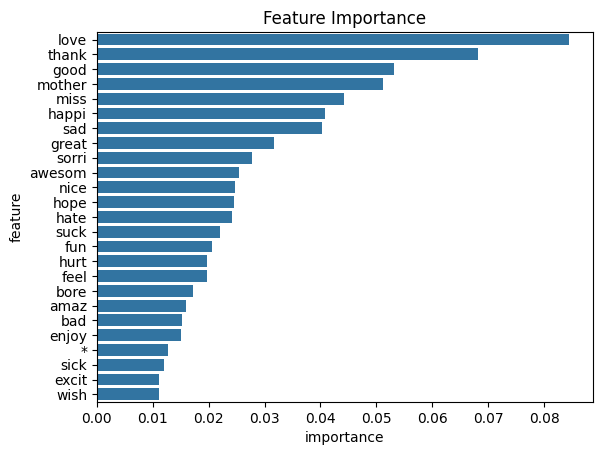

In [40]:
import  seaborn as sns

importance_df = pd.DataFrame({
    'feature': bow_vectorizer.get_feature_names_out(),
    'importance': bow_dt_best.feature_importances_
    }).sort_values('importance', ascending=False)

plt.title('Feature Importance')
sns.barplot(data=importance_df.head(25), x='importance', y='feature')

In [41]:
importance_df

,feature,importance
547,love,0.084514
859,thank,0.068151
397,good,0.053185
598,mother,0.051160
586,miss,0.044243
...,...,...
349,find,0.000000
350,fine,0.000000
351,finger,0.000000
352,finish,0.000000


Розподіл важливості слів є доволі логічним. Слова як `love`, `good`, `miss`, `sad`, `hate` є емоціійними і показують настрій, тоді як слова типу `find`, `fine`, `finger`, `fnish`, `yup` є доволі нейтральними і мало кажуть про настрій автора

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    tokenizer=tokenize,
    stop_words=english_stopwords,
    max_features=max_features
)

tfidf_vectors = tfidf_vectorizer.fit_transform(raw_df.text)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


In [44]:
tfidf_X = tfidf_vectors

X_train_tfidf, X_test_tfidf = tfidf_X[train_index], tfidf_X[test_index]

In [52]:
tfidf_dt_random = RandomizedSearchCV(tree_model, params_dt, scoring='f1_macro', random_state=42, cv=3, n_jobs=5, n_iter=500)
tfidf_dt_random.fit(X_train_tfidf, y_train)
tfidf_best = tfidf_dt_random.best_estimator_

In [71]:
tfidf_dt_random.best_params_

{'splitter': 'random',
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 98,
 'max_features': None,
 'max_depth': 625,
 'criterion': 'gini'}

In [54]:
print('Train: ',f1_score(y_train, tfidf_best.predict(X_train_tfidf), average='macro'))
print('Test: ', f1_score(y_test, tfidf_best.predict(X_test_tfidf), average='macro'))

Train:  0.6674100832723336
Test:  0.6538168244531334


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

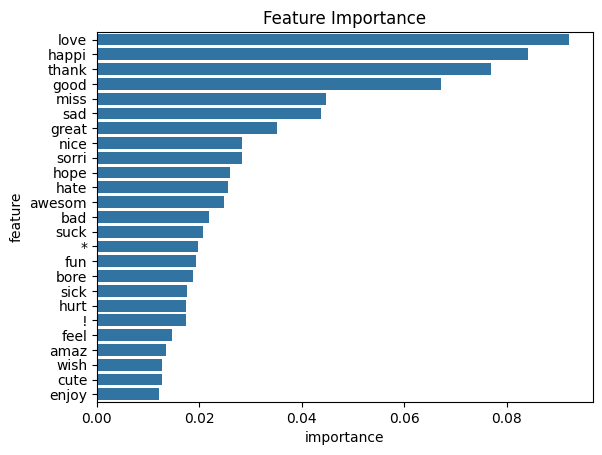

In [55]:
importance_df = pd.DataFrame({
    'feature': tfidf_vectorizer.get_feature_names_out(),
    'importance': tfidf_best.feature_importances_
    }).sort_values('importance', ascending=False)

plt.title('Feature Importance')
sns.barplot(data=importance_df.head(25), x='importance', y='feature')

In [56]:
importance_df

,feature,importance
547,love,0.092196
422,happi,0.084166
859,thank,0.076993
397,good,0.067220
586,miss,0.044633
...,...,...
376,front,0.000000
377,full,0.000000
31,2nd,0.000000
30,2day,0.000000


Друга модель дала трохи гірший результат, проте якщо поглянути на важливість токенів у другому випадку вони виглядають трохи більше логічними у кінці списку, тому поки що я б використовувала першу модель, але можливо є сенс спробувати підібрати кращі параметри для другої

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [91]:
# Додамо стовпчики з передбаченнями моделей
raw_df['bow_prediction'] = bow_dt_best.predict(bow_vectors)
raw_df['tfidf_prediction'] = tfidf_best.predict(bow_vectors)

# Додамо стовпчики з передбаченнями ймовірностей tfidf моделі
raw_df['tfidf_negative_prob'], raw_df['tfidf_neutral_prob'] , raw_df['tfidf_positive_prob']  = tfidf_best.predict_proba(bow_vectors).T

# Відсортуємо записи на яких tfidf модель зробила помилку
error_df = raw_df[(raw_df['tfidf_prediction'] != raw_df['sentiment'])]
error_df[:20]

,textID,text,selected_text,sentiment,bow_prediction,tfidf_prediction,tfidf_negative_prob,tfidf_neutral_prob,tfidf_positive_prob
2,088c60f138,my boss is bullying me...,bullying me,negative,neutral,neutral,0.187216,0.685953,0.126832
3,9642c003ef,what interview! leave me alone,leave me alone,negative,neutral,neutral,0.243819,0.522321,0.233860
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,positive,positive,0.113636,0.215909,0.670455
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,neutral,neutral,0.243819,0.522321,0.233860
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,positive,positive,0.039752,0.141615,0.818634
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,neutral,neutral,0.187216,0.685953,0.126832
15,8a939bfb59,"Uh oh, I am sunburned","Uh oh, I am sunburned",negative,neutral,neutral,0.187216,0.685953,0.126832
20,04d17ef61e,"oh Marly, I`m so sorry!! I hope you find her...","oh Marly, I`m so sorry!! I hope you find her ...",neutral,neutral,negative,0.764706,0.208824,0.026471
27,bdc32ea43c,On the way to Malaysia...no internet access to...,.no internet,negative,neutral,neutral,0.187216,0.685953,0.126832
29,d22e6d40a7,Went to sleep and there is a power cut in Noid...,Power back up not working too,negative,neutral,neutral,0.187216,0.685953,0.126832


In [94]:
# Подивимось на якому класі модель зробила найбільше помилок
error_df.sentiment.value_counts()

sentiment
negative    3885
positive    2657
neutral     2463
Name: count, dtype: int64

In [96]:
raw_df.sentiment.value_counts()


sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

Для поліпшення якості класифікації можна:

* Спробувати інші, більш складні, архітектури моделей 
* Модель зробила найбільшу кількість помилок на негативних документах і їх було найменше в оригінальних даних, тому для поліпшення класифікації можна спробувати збалансувати дані
* Спробувати іншу довжину вектора словника

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model